In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import traceback

In [2]:
%matplotlib inline

In [3]:
# path constants
PATH_DATA = "data"
PATH_COMPUTED_DATA = "data_computed"

In [4]:
# mel spectogram parameters
MEL_N_FFT = 1024
MEL_HOP_LENGTH = 512
MEL_NUM_MELS = 128

In [5]:
# others
LIMIT_FILE_COUNT = None  # None for no limit

In [6]:
# helper function to compute melspectogram, with default parameters
def mel(sample, sr, n_fft=MEL_N_FFT, hop_length=MEL_HOP_LENGTH, n_mels=MEL_NUM_MELS):
    S = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    return librosa.power_to_db(S, ref=np.max)

In [7]:
# helper function to help visualise audio in a Jupyter notebook
def visualize(sample=None, sr=None, S=None, hop_length=MEL_HOP_LENGTH):
    # compute S from sample and sr if not already provided
    if S is None and (sample is not None and sr is not None):
        S = mel(sample, sr, hop_length=hop_length)
        
    if sample is not None:
        # embed audio
        IPython.display.display(IPython.display.Audio(sample, rate=sr))
        
        # plot sample
        plt.plot(sample)
        plt.title("Audio Sample")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()
        
    # plot mel
    if S is not None:
        librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

In [8]:
# data augmentation functions
add_noise = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1.0),
])
pitch_shift = Compose([
    PitchShift(min_semitones=-4, max_semitones=12, p=1.0),
])
augmentation_functions = [add_noise, pitch_shift]

## Data Augmentation Experimentation

In [9]:
sample, sr = librosa.load('data/blues/blues.00000.wav')

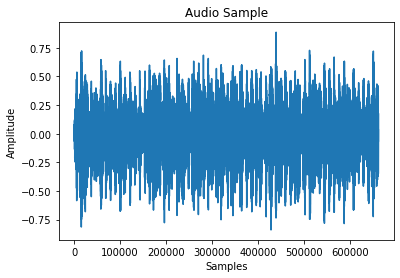

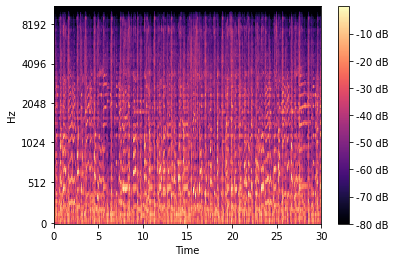

In [10]:
# original
visualize(sample, sr)

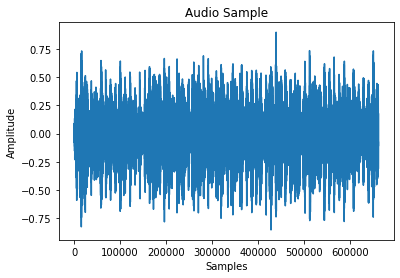

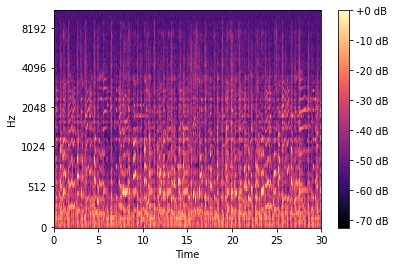

In [11]:
# noise
noise_sample = add_noise(sample, sample_rate=sr)
visualize(noise_sample, sr)

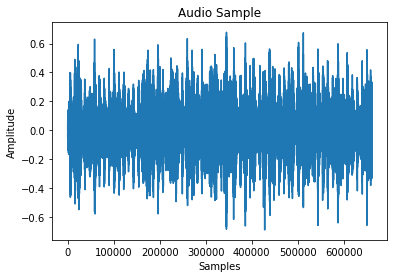

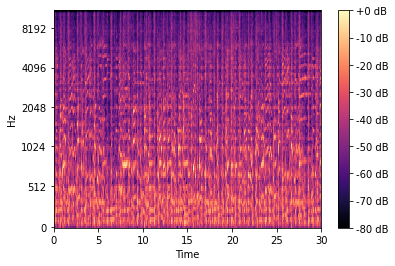

In [12]:
# pitch
pitch_sample = pitch_shift(sample, sample_rate=sr)
visualize(pitch_sample, sr)

## Build Dataset

In [13]:
from tqdm import tqdm
from pathlib import Path
import shutil

In [14]:
# load raw samples and related info into memory
# ('raw' because mel-spec features have not been computed for them)
raw_data = []  # list of (sample, sample rate, label) tuples

for wav_file in tqdm(Path(PATH_DATA).rglob("*.wav")):
    try:
        sample, sr = librosa.load(wav_file, duration=28)
        label = wav_file.parent.name  # parent file's name is the corresponding label

        raw_data.append((sample, sr, label))
    except:
        print("Error in file", wav_file)
        traceback.print_exc()  # print traceback

    if LIMIT_FILE_COUNT is not None:
        if len(raw_data) >= LIMIT_FILE_COUNT:
            break

532it [00:02, 269.96it/s]C:\Users\ab\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
Traceback (most recent call last):
  File "C:\Users\ab\AppData\Roaming\Python\Python310\site-packages\librosa\core\audio.py", line 155, in load
    context = sf.SoundFile(path)
  File "C:\Users\ab\AppData\Roaming\Python\Python310\site-packages\soundfile.py", line 629, in __init__
    self._file = self._open(file, mode_int, closefd)
  File "C:\Users\ab\AppData\Roaming\Python\Python310\site-packages\soundfile.py", line 1183, in _open
    _error_check(_snd.sf_error(file_ptr),
  File "C:\Users\ab\AppData\Roaming\Python\Python310\site-packages\soundfile.py", line 1357, in _error_check
    raise RuntimeError(prefix + _ffi.string(err_str).decode('utf-8', 'replace'))
RuntimeError: Error opening 'data\\jazz\\jazz.00054.wav': File contains data in an unknown format.

During handling of the above e

Error in file data\jazz\jazz.00054.wav


1000it [00:06, 163.65it/s]


In [15]:
# split raw data
import random
random.seed(10)

# uniformly randomise the order of the data
random.shuffle(raw_data)

train_size = 0.80
train_n = int(train_size*len(raw_data))

raw_data_train = raw_data[:train_n]
raw_data_test = raw_data[train_n:]

print(f"Split {len(raw_data)} data points into {len(raw_data_train)} (train) and {len(raw_data_test)} (test)")

Split 999 data points into 799 (train) and 200 (test)


In [16]:
# compute mel + augment data

def build_data(_raw_data, augment=True):
    """
    Computes mel-spec features (and optionally generate augmented data) for the input data.
    NOTE: this will mutate and remove all elements in the input list (to conserve memory)
    :param augment: whether to augment the data or not
    """
    # resulting arrays
    X = []
    Y = []

    initial_len = len(_raw_data)
    with tqdm(total=initial_len) as pbar:
        while len(_raw_data) > 0:
            x, sr, y = _raw_data.pop()

            # compute mel, append to X and append corresponding label to Y
            mel_x = mel(x, sr)
            X.append(mel_x)
            Y.append(y)

            if augment:
                for augmentation_function in augmentation_functions:
                    x_aug = augmentation_function(x, sr)

                    # compute mel for augmented x, append to X and append corresponding label to Y
                    mel_x_aug = mel(x_aug, sr)
                    X.append(mel_x_aug)
                    Y.append(y)

            pbar.update()

    # convert X and Y into numpy arrays
    X = np.asarray(X)
    Y = np.asarray(Y)

    # and also shuffle them
    indices = np.arange(len(X))  # shuffled indices are computed so that we can shuffle two arrays together
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    print(f"Finished building data! Number of data points: {initial_len} -> {len(X)}")
    return X, Y

print("Building training data set:")
X_train, Y_train = build_data(raw_data_train, augment=True)

print("Building testing data set:")
X_test, Y_test = build_data(raw_data_test, augment=False)  # do not augment for test data !

Building training data set:


100%|██████████| 799/799 [16:27<00:00,  1.24s/it]


Finished building data! Number of data points: 799 -> 2397
Building testing data set:


0it [00:00, ?it/s]

Finished building data! Number of data points: 0 -> 0


### Cache Computed Data to Disk

In [21]:
path_computed_data = Path(PATH_COMPUTED_DATA)
if path_computed_data.exists():
    print("Warning! computed data directory already exists. Press enter to overwrite it with the newly computed data")
    input()
    shutil.rmtree(path_computed_data)

path_computed_data.mkdir(parents=True, exist_ok=False)

# save computed data
np.save(path_computed_data / "X_train.npy", X_train)
np.save(path_computed_data / "Y_train.npy", Y_train)
np.save(path_computed_data / "X_test.npy", X_test)
np.save(path_computed_data / "Y_test.npy", Y_test)

print("Saved!")

Saved!
